## 1st Try:
### PatchTST & TemporalFusionTransformer with combined_data.parquet
##### 1/19/2025

In [2]:
# !pip install uv
# !uv pip install -q autogluon.timeseries --system
# !uv pip uninstall -q torchaudio torchvision torchtext --system # fix incompatible package versions on Colab

  Using cached uv-0.5.21-py3-none-win_amd64.whl.metadata (11 kB)
Using cached uv-0.5.21-py3-none-win_amd64.whl (16.6 MB)


error: Failed to parse: `#`
  Caused by: Expected package name starting with an alphanumeric character, found `#`
#
^


### packages

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.timeseries.models import PatchTSTModel, TemporalFusionTransformerModel
from plotnine import *

### data

In [3]:
df = pd.read_parquet("../combined_data/combined_data.parquet")
df.head()

,T_REC,USFLUX,MEANGAM,MEANGBT,MEANGBZ,MEANGBH,MEANJZD,TOTUSJZ,MEANALP,MEANJZH,...,NPIX,SIZE,AREA,NACR,SIZE_ACR,AREA_ACR,flux,max_flux_next_24h,max_flare_class_next_24h,max_peak_intensity_next_24h
0,2010-05-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.615019e-08,0.000008,C,0.000008
1,2010-05-01 00:12:00+00:00,1.439345e+21,32.159885,137.783195,137.832428,59.383249,0.528793,2.065877e+12,0.001307,-0.000677,...,21385.121136,1908.233367,1124.079598,1636.651525,146.041405,86.298480,6.331756e-08,0.000008,C,0.000008
2,2010-05-01 00:24:00+00:00,1.488903e+21,32.006564,138.032814,137.932202,58.588763,0.355526,2.096785e+12,0.001291,-0.000588,...,22631.582458,2019.510773,1188.056979,1754.132156,156.528544,92.311965,6.583243e-08,0.000008,C,0.000008
3,2010-05-01 00:36:00+00:00,1.495132e+21,32.489844,136.413847,136.048735,59.049505,0.317466,2.190448e+12,-0.001002,-0.001128,...,23156.134658,2066.389478,1214.339188,1786.976723,159.464861,93.905701,7.199385e-08,0.000008,C,0.000008
4,2010-05-01 00:48:00+00:00,1.566065e+21,31.843583,136.656334,136.326496,58.237536,0.342064,2.305668e+12,-0.000914,-0.000872,...,24186.736691,2158.422429,1267.802766,1847.651398,164.884269,97.054212,6.824671e-08,0.000008,C,0.000008


In [4]:
df.dtypes

T_REC                          datetime64[ns, UTC]
USFLUX                                     float64
MEANGAM                                    float64
MEANGBT                                    float64
MEANGBZ                                    float64
MEANGBH                                    float64
MEANJZD                                    float64
TOTUSJZ                                    float64
MEANALP                                    float64
MEANJZH                                    float64
TOTUSJH                                    float64
ABSNJZH                                    float64
SAVNCPP                                    float64
MEANPOT                                    float64
TOTPOT                                     float64
MEANSHR                                    float64
SHRGT45                                    float64
NPIX                                       float64
SIZE                                       float64
AREA                           

### Model with all same item_id

In [4]:
df_single_item = df.copy()
df_single_item['item_id'] = 0
df_single_item = df_single_item[[df_single_item.columns[-1]] + list(df_single_item.columns[:-1])]
df_single_item.rename(columns={'T_REC':'timestamp'}, inplace=True)
df_single_item['timestamp'] = df_single_item['timestamp'].dt.tz_localize(None)

df_single_item = df_single_item.ffill() # fill missing values with previous one
df_single_item = df_single_item.iloc[1:,] # drop the 1st row

df_single_item = df_single_item.iloc[:, 0:-3]
df_single_item = df_single_item.iloc[:11000,:]
df_single_item["target"] = df_single_item["USFLUX"]

df_single_item = TimeSeriesDataFrame.from_data_frame(df_single_item)

prediction_length_2 = 1000 

train_data_2, test_data_2 = df_single_item.train_test_split(prediction_length_2)

print(len(train_data_2), len(test_data_2))


10000 11000


In [5]:
df_single_item.head()

USFLUX    MEANGAM     MEANGBT     MEANGBZ  \
item_id timestamp                                                              
0       2010-05-01 00:12:00  1.439345e+21  32.159885  137.783195  137.832428   
        2010-05-01 00:24:00  1.488903e+21  32.006564  138.032814  137.932202   
        2010-05-01 00:36:00  1.495132e+21  32.489844  136.413847  136.048735   
        2010-05-01 00:48:00  1.566065e+21  31.843583  136.656334  136.326496   
        2010-05-01 01:00:00  1.581636e+21  32.029743  136.771497  136.505656   

                               MEANGBH   MEANJZD       TOTUSJZ   MEANALP  \
item_id timestamp                                                          
0       2010-05-01 00:12:00  59.383249  0.528793  2.065877e+12  0.001307   
        2010-05-01 00:24:00  58.588763  0.355526  2.096785e+12  0.001291   
        2010-05-01 00:36:00  59.049505  0.317466  2.190448e+12 -0.001002   
        2010-05-01 00:48:00  58.237536  0.342064  2.305668e+12 -0.000914   
        2010-05-01 01:00:00  58.079512  0.160927  2.233088e+12 -0.000352   

                              MEANJZH     TOTUSJH  ...    MEANSHR   SHRGT45  \
item_id timestamp                                  ...                        
0       2010-05-01 00:12:00 -0.000677  103.413242  ...  24.980931  7.166919   
        2010-05-01 00:24:00 -0.000588  104.334118  ...  24.549219  6.112795   
        2010-05-01 00:36:00 -0.001128  105.544694  ...  25.103040  7.290995   
        2010-05-01 00:48:00 -0.000872  110.540304  ...  24.838363  6.565928   
        2010-05-01 01:00:00 -0.001005  107.304800  ...  24.577836  6.317723   

                                     NPIX         SIZE         AREA  \
item_id timestamp                                                     
0       2010-05-01 00:12:00  21385.121136  1908.233367  1124.079598   
        2010-05-01 00:24:00  22631.582458  2019.510773  1188.056979   
        2010-05-01 00:36:00  23156.134658  2066.389478  1214.339188   
        2010-05-01 00:48:00  24186.736691  2158.422429  1267.802766   
        2010-05-01 01:00:00  24679.478496  2202.451682  1292.445468   

                                    NACR    SIZE_ACR   AREA_ACR          flux  \
item_id timestamp                                                               
0       2010-05-01 00:12:00  1636.651525  146.041405  86.298480  6.331756e-08   
        2010-05-01 00:24:00  1754.132156  156.528544  92.311965  6.583243e-08   
        2010-05-01 00:36:00  1786.976723  159.464861  93.905701  7.199385e-08   
        2010-05-01 00:48:00  1847.651398  164.884269  97.054212  6.824671e-08   
        2010-05-01 01:00:00  1889.395343  168.613857  99.122971  6.633540e-08   

                                   target  
item_id timestamp                          
0       2010-05-01 00:12:00  1.439345e+21  
        2010-05-01 00:24:00  1.488903e+21  
        2010-05-01 00:36:00  1.495132e+21  
        2010-05-01 00:48:00  1.566065e+21  
        2010-05-01 01:00:00  1.581636e+21  

[5 rows x 24 columns]

In [ ]:
# known_covariates_names = df_single_item.columns[1:6]
# known_covariates_names

In [6]:
predictor = TimeSeriesPredictor(
    freq = "12T",
    prediction_length= prediction_length_2, # 1000
    #target= "target",
    #known_covariates_names= known_covariates_names,
).fit(
    train_data_2,
    hyperparameters={
        "PatchTST": [
            # Zero-shot model WITHOUT covariates
            {
                #"model_path": "bolt_small", # only the historical values of unit_sales
                "target_scaler": "standard",
                #"ag_args": {"name_suffix": "ZeroShot"},
                #"nhead": 5,
            }#,

            # {
            #     "model_path": "bolt_small",
            #     "covariate_regressor": "CAT",
            #     "target_scaler": "standard",
            #     "ag_args": {"name_suffix": "WithRegressor"},
            #     #"nhead": 8,
            # }

        ]#,

        # "TemporalFusionTransformerModel": [
        #     # Zero-shot model WITHOUT covariates
        #     {
        #         "model_path": "bolt_small", # only the historical values of unit_sales
        #         "ag_args": {"name_suffix": "ZeroShot"},
        #         #"hidden_dim": 64,
        #     },

        #     {
        #         "model_path": "bolt_small",
        #         "covariate_regressor": "CAT",
        #         "target_scaler": "standard",
        #         "ag_args": {"name_suffix": "WithRegressor"},
        #         #"hidden_dim": 124,
        #     }

        # ]
    },
    enable_ensemble= False, #False, 
    time_limit= 120,
)

c:\Users\Administrator\Desktop\URPS\urps_2025\autogluon_env\Lib\site-packages\autogluon\timeseries\predictor.py:197: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  std_freq = pd.tseries.frequencies.to_offset(self.freq).freqstr
Frequency '12T' stored as '12min'
Beginning AutoGluon training... Time limit = 120s
AutoGluon will save models to 'c:\Users\Administrator\Desktop\URPS\urps_2025\notebooks\AutogluonModels\ag-20250121_161613'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          16
GPU Count:          0
Memory Avail:       3.02 GB / 15.73 GB (19.2%)
Disk Space Avail:   68.62 GB / 200.00 GB (34.3%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'freq': '12min',
 'hyperparameters': {'PatchTST': [{'target_scaler': 'standard'}]},
 'known_covariates_name

In [22]:
predictor.leaderboard(test_data_2)

data with frequency 'None' has been resampled to frequency '12min'.
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,PatchTST,-0.427658,-0.530565,0.180049,0.071027,114.828286,1


In [7]:
y_bar = predictor.predict(train_data_2)["mean"]
y_bar

data with frequency 'None' has been resampled to frequency '12min'.
Model not specified in predict, will default to the model with the best validation score: PatchTST


item_id  timestamp          
0        2010-07-26 20:48:00    1.335535e+22
         2010-07-26 21:00:00    1.458829e+22
         2010-07-26 21:12:00    1.488282e+22
         2010-07-26 21:24:00    1.396285e+22
         2010-07-26 21:36:00    1.360978e+22
                                    ...     
         2010-08-04 03:48:00    5.447709e+21
         2010-08-04 04:00:00    6.909893e+21
         2010-08-04 04:12:00    7.277688e+21
         2010-08-04 04:24:00    7.087658e+21
         2010-08-04 04:36:00    6.513895e+21
Name: mean, Length: 1000, dtype: float64

In [13]:
plot_df = pd.DataFrame( {
    #"timestamp": test_data_2["ti"],
    "pred" : y_bar,
    "actual": test_data_2["target"].iloc[-1000:,]
})

plot_df.reset_index(inplace=True)

In [16]:
plot_df[["pred", "actual"]] = plot_df[["pred", "actual"]] / 1e21

In [17]:
plot_df

,item_id,timestamp,pred,actual
0,0,2010-07-26 20:48:00,13.355353,15.633330
1,0,2010-07-26 21:00:00,14.588290,15.644839
2,0,2010-07-26 21:12:00,14.882816,15.597534
3,0,2010-07-26 21:24:00,13.962848,15.387769
4,0,2010-07-26 21:36:00,13.609776,15.413974
...,...,...,...,...
995,0,2010-08-04 03:48:00,5.447709,7.975989
996,0,2010-08-04 04:00:00,6.909893,7.954468
997,0,2010-08-04 04:12:00,7.277688,8.074063
998,0,2010-08-04 04:24:00,7.087658,8.060148


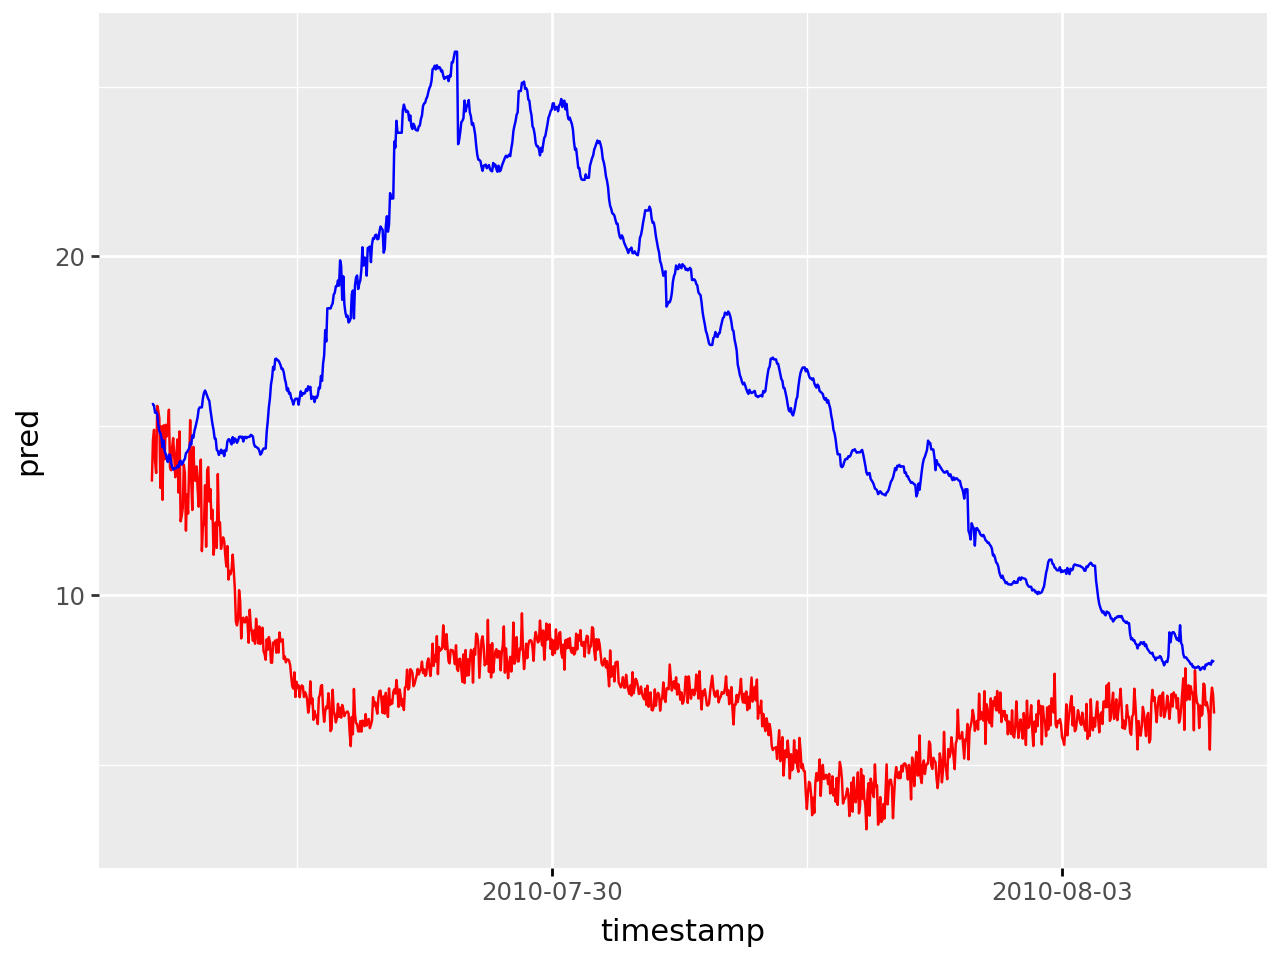

In [18]:
(
    ggplot(data=plot_df, mapping=aes(x= "timestamp")) +
    geom_line(aes(y = "pred"), color = "red") + 
    geom_line(aes(y = "actual"), color = "blue")
)